# Query historical LP yield from Uniswap subgraph

Using version 2

Checking against https://v2.info.uniswap.org/pairs
which currently returns 6.66% for USDC/USDT. Looks about right?

In [1]:
%matplotlib inline
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
plt.style.use('bmh')

import pandas as pd
from tqdm.notebook import tqdm
from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport

In [2]:
transport = RequestsHTTPTransport(
    url='https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v2',
    verify=True,
    retries=3,
)
client = Client(transport=transport)

# Token

Get token ID needed for the query later on.

In [3]:
query = gql('''
{
  tokens (
    first: 10
    orderBy:tradeVolumeUSD
    orderDirection:desc
  ){
    id
    symbol
    tradeVolumeUSD
  }
}
''')

In [4]:
resp = client.execute(query)

In [5]:
tokens = pd.DataFrame(resp['tokens']).set_index('symbol')
tokens['tradeVolumeUSD'] = tokens['tradeVolumeUSD'].astype(float)
tokens

,id,tradeVolumeUSD
symbol,,
WETH,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,3.364376e+11
USDC,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,4.723298e+10
USDT,0xdac17f958d2ee523a2206206994597c13d831ec7,4.081934e+10
DAI,0x6b175474e89094c44da98b954eedeac495271d0f,1.800987e+10
SCAMMY,0x05934eba98486693aaec2d00b0e9ce918e37dc3f,1.102972e+10
welp,0x3d7e683fc9c86b4d653c9e47ca12517440fad14e,1.101764e+10
Ian Laphan fan token,0xfae9c647ad7d89e738aba720acf09af93dc535f7,1.096054e+10
generalize fix for rebass tokens,0x7296368fe9bcb25d3ecc19af13655b907818cc09,1.093154e+10
WBTC,0x2260fac5e5542a773aa44fbcfedf7c193bc2c599,9.038477e+09


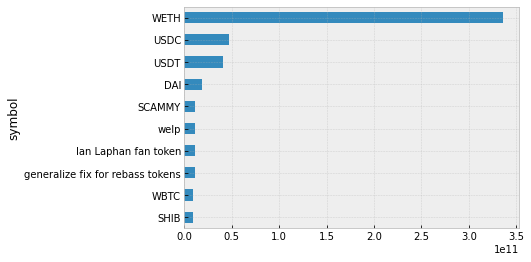

In [6]:
tokens['tradeVolumeUSD'].iloc[::-1].plot(kind='barh');

# Pair

Next get available token pairs

In [7]:
query = gql('''
{
	pairs (
    first: 200
    orderBy:volumeUSD
    orderDirection: desc
  ){
    token0{
      symbol
    }
    token1{
      symbol
    }
    volumeUSD
  }
}

''')

In [8]:
resp = client.execute(query)

In [9]:
pairs = []
for i in resp['pairs']:
    pairs.append([
        i['token0']['symbol'],
        i['token1']['symbol'],
        float(i['volumeUSD'])
    ])
    
pairs = pd.DataFrame(pairs, columns=['token0', 'token1', 'volumeUSD'])

In [10]:
pairs.head()

,token0,token1,volumeUSD
0,USDC,WETH,3.436709e+10
1,WETH,USDT,3.347197e+10
2,DAI,WETH,1.477108e+10
3,SCAMMY,WETH,1.102972e+10
4,welp,WETH,1.101764e+10


Volume is concentrated in WETH pairs.

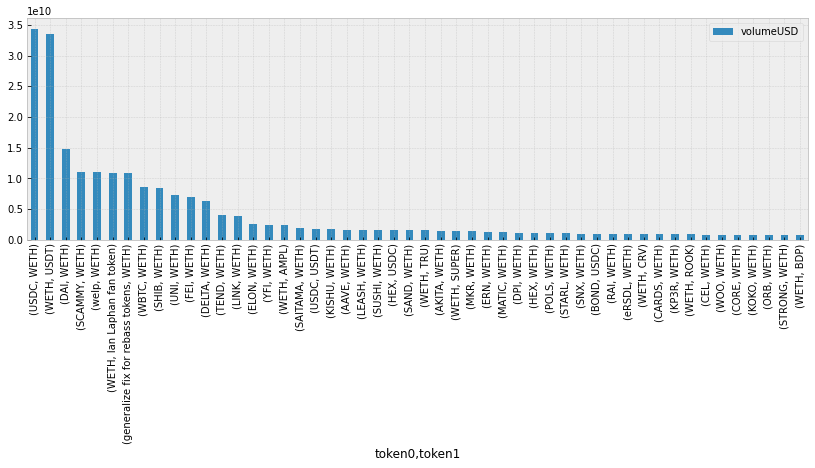

In [11]:
pairs.set_index(['token0', 'token1']).head(50).plot(kind='bar', figsize=(14, 4));

# Liquidity pool yield

Let's query historical yield by providing liquidity in stable coin pairs.

In [12]:
def query_lp(token0: str, token1: str) -> str:
    id0 = tokens.at[token0, 'id']
    id1 = tokens.at[token1, 'id']
    
    query = ("""
    query {
      pairDayDatas (
        first: 1000
        where: {
          token0: "TOKEN0"
          token1: "TOKEN1"
        }
        orderBy: date
        orderDirection: asc
      ){
        id
        date
        token0 {
          id
          symbol
        }
        token1{
          id
          symbol
        }
        dailyVolumeUSD
        reserve0
        reserve1
        reserveUSD
      }
    }
    """)
    # fixme is there a better way?
    query = query.replace('TOKEN0', id0)
    query = query.replace('TOKEN1', id1)
    return query

    
def get_lp_apy(token0: str, token1: str) -> pd.DataFrame:
    query = gql(query_lp(token0, token1))
    resp = client.execute(query)
    
    result = []

    for row in tqdm(resp['pairDayDatas'], leave=False):
        result.append([
            datetime.fromtimestamp(row['date']),
            float(row['dailyVolumeUSD']),
            float(row['reserveUSD']),
        ])

    result = pd.DataFrame(result, 
                          columns=['date', 'volume', 'reserve']).set_index('date')
    result['apy'] = result['volume'].mul(30 / 10000) / result['reserve'] * 365
    return result

These pairs are not the most traded pairs by all means, pariculalry DAI pairs.

In [13]:
pairs.query('token0 in ("USDT", "USDC", "DAI") and token1 in ("USDT", "USDC", "DAI")')

,token0,token1,volumeUSD
18,USDC,USDT,1.796071e+09
107,DAI,USDC,4.417307e+08
159,DAI,USDT,3.018601e+08


In [14]:
usdc_usdt = get_lp_apy('USDC', 'USDT')

In [15]:
dai_usdc = get_lp_apy('DAI', 'USDC')

In [16]:
dai_usdt = get_lp_apy('DAI', 'USDT')

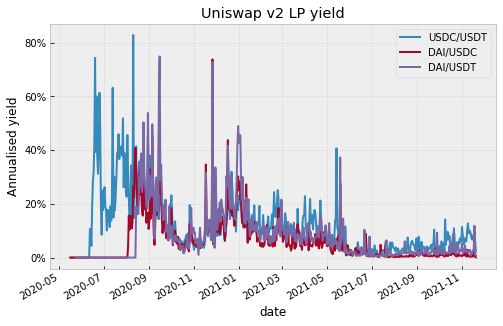

In [17]:
fig, ax = plt.subplots(figsize=(8, 5))
usdc_usdt['apy'].plot(ax=ax, label='USDC/USDT')
dai_usdc['apy'].plot(ax=ax, label='DAI/USDC')
dai_usdt['apy'].plot(ax=ax, label='DAI/USDT')

ax.legend();
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1, decimals=0))
ax.set_title('Uniswap v2 LP yield')
ax.set_ylabel('Annualised yield');

Yield was pretty high despite of the fact that these are stable coins until the crypto crash in May-2021. After that yield collapsed to lower single digits. Recently that of USDC/USDT is gradually going up again.

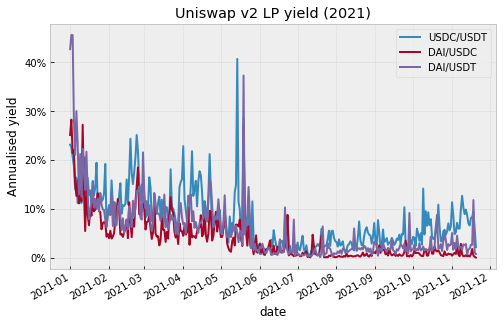

In [18]:
fig, ax = plt.subplots(figsize=(8, 5))
usdc_usdt['apy']['2021'].plot(ax=ax, label='USDC/USDT')
dai_usdc['apy']['2021'].plot(ax=ax, label='DAI/USDC')
dai_usdt['apy']['2021'].plot(ax=ax, label='DAI/USDT')

ax.legend();
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1, decimals=0))
ax.set_title('Uniswap v2 LP yield (2021)')
ax.set_ylabel('Annualised yield');

In [19]:
pd.concat((
    usdc_usdt['apy'].rename('USDC/USDT'),
    dai_usdc['apy'].rename('DAI/USDC'),
    dai_usdt['apy'].rename('DAI/USDT'),
), axis=1).tail(20).mul(100)

,USDC/USDT,DAI/USDC,DAI/USDT
date,,,
2021-11-01,11.410495,0.492724,5.131044
2021-11-02,8.670594,0.807312,1.718383
2021-11-03,4.881569,1.061648,3.087242
2021-11-04,5.238421,0.846460,1.871402
2021-11-05,7.210349,2.721639,4.579301
2021-11-06,6.054020,0.775872,2.208684
2021-11-07,6.026914,0.384245,2.218450
2021-11-08,9.894480,2.914623,2.273798
2021-11-09,12.734830,0.739453,1.772877
